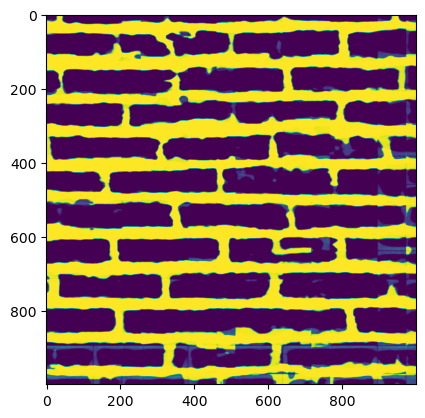

In [1]:
#data load individual
from skimage.io import imread
import numpy as np
import os
import torch
import matplotlib.pyplot as plt
os.chdir("../data")
import albumentations as A
from albumentations.pytorch import ToTensorV2
datapath = "randomproptest_14/test0/results/picoutdepthUnetPlusPlusmobilenet_v2wall2.tiff"
trans = A.Compose([
        ToTensorV2()])
data = imread(datapath)
data = data/data.max()
transformed = trans(image=data, mask=data)
x = transformed['image']
x = x*data.max()
plt.imshow(x[0])

In [2]:
# datapath = "randomproptest_14/test0/results/picoutdepthUnetmobilenet_v2.tiff"
# trans = A.Compose([
#         ToTensorV2()])
# data = imread(datapath)
# data = data/data.max()
# transformed = trans(image=data, mask=data)
# x = transformed['image']
# x = x*data.max()
# plt.imshow(x[0])

In [3]:
x[0].shape[0]

1000

In [4]:
hjoints = torch.sum(x[0],dim =1)/x[0].shape[1]


In [5]:
hjoints.max()

tensor(1., dtype=torch.float64)

In [6]:
THRESHOLD = min(torch.mean(hjoints)+torch.std(hjoints),0.99)
hjoints = hjoints>THRESHOLD
hjointloc = hjoints
hjoints = torch.unsqueeze(hjoints,1)
hjoints = hjoints*torch.ones(x[0].shape)

In [7]:
hjoints

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

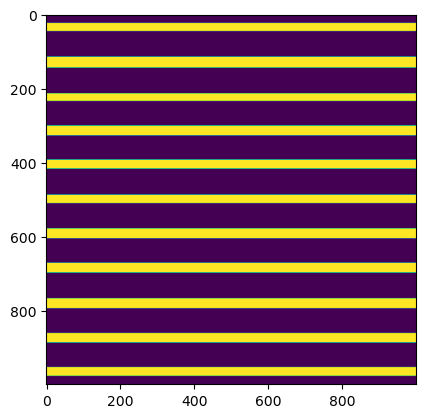

In [8]:
plt.imshow(hjoints)

In [9]:
x1 = x[0]+hjoints

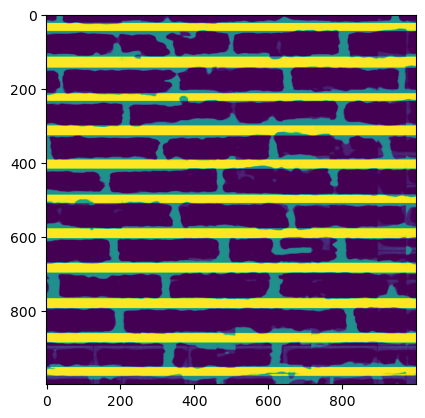

In [10]:
plt.imshow(x1)

In [11]:

a= False
startx = hjointloc*0
endx = hjointloc*0
for X in range(0,len(hjointloc)):
    print('x,a')
    print(hjointloc[X])
    print(a)
    
    if hjointloc[X] == True and a == False:
         endx[X] = 1
         print("end")
    if hjointloc[X] == False and a == True:
         startx[X] = 1
         print("start")
    a = hjointloc[X]
#endx[0]=0
#endx[-1]=1
    

x,a
tensor(False)
False
x,a
tensor(False)
tensor(False)
x,a
tensor(False)
tensor(False)
x,a
tensor(False)
tensor(False)
x,a
tensor(False)
tensor(False)
x,a
tensor(False)
tensor(False)
x,a
tensor(False)
tensor(False)
x,a
tensor(False)
tensor(False)
x,a
tensor(False)
tensor(False)
x,a
tensor(False)
tensor(False)
x,a
tensor(False)
tensor(False)
x,a
tensor(False)
tensor(False)
x,a
tensor(False)
tensor(False)
x,a
tensor(False)
tensor(False)
x,a
tensor(False)
tensor(False)
x,a
tensor(False)
tensor(False)
x,a
tensor(False)
tensor(False)
x,a
tensor(False)
tensor(False)
x,a
tensor(False)
tensor(False)
x,a
tensor(False)
tensor(False)
x,a
tensor(False)
tensor(False)
x,a
tensor(False)
tensor(False)
x,a
tensor(False)
tensor(False)
x,a
tensor(False)
tensor(False)
x,a
tensor(True)
tensor(False)
end
x,a
tensor(True)
tensor(True)
x,a
tensor(True)
tensor(True)
x,a
tensor(True)
tensor(True)
x,a
tensor(True)
tensor(True)
x,a
tensor(True)
tensor(True)
x,a
tensor(True)
tensor(True)
x,a
tensor(True)
tensor(T

In [12]:
startindex = startx.nonzero()
endindex = endx.nonzero()

In [13]:
startx.size()[0]

1000

In [14]:
torch.zeros(3)


tensor([0., 0., 0.])

In [15]:
endindex

tensor([[ 24],
        [115],
        [214],
        [301],
        [393],
        [488],
        [579],
        [672],
        [768],
        [862],
        [954]])

In [16]:
if startindex[0] > endindex[0]:
    startindex = torch.cat((torch.zeros(1).unsqueeze(0), startindex))
    

In [17]:
if startindex[-1] > endindex[-1]:
    endindex = torch.cat((endindex, (startx.size()[0]-1)*torch.ones(1).unsqueeze(0)))

In [39]:
startindex[0]

tensor([0.])

In [19]:
endindex

tensor([[ 24.],
        [115.],
        [214.],
        [301.],
        [393.],
        [488.],
        [579.],
        [672.],
        [768.],
        [862.],
        [954.],
        [999.]])

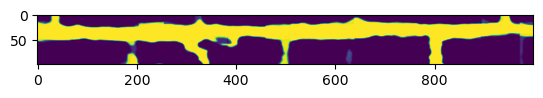

In [20]:
plt.imshow(x[0][1:100,:])

In [50]:
x2 = hjoints
widthadd = 1
widthcheck = widthadd*2 +1
for start, end in zip(startindex,endindex):
    vjoints = 0*torch.sum(x[0][int(start.item()):int(end.item()),:],dim =0)
    for n in range(0, widthcheck):
        vjoints[(widthadd):(-widthadd)] += torch.sum(x[0][int(start.item()):int(end.item()),(0+n):x[0].shape[1]-widthcheck+n+1],dim =0)/(widthcheck*(end.item()-start.item()))

    THRESHOLD = min(torch.mean(vjoints)+torch.std(vjoints),0.99)
    vjoints = vjoints> 0.5 #THRESHOLD
    vjointloc = vjoints
    vjoints = torch.unsqueeze(vjoints,0)
    vjoints = vjoints*torch.ones(x[0][int(start.item()):int(end.item()),:].shape)
    x2[int(start.item()):int(end.item()),:] = vjoints + hjoints[int(start.item()):int(end.item()),:]#x1[start:end,:]+vjoints

In [51]:
int(start.item())

978

In [52]:
x[0][startindex[1][0]:endindex[1][0],:]

TypeError: only integer tensors of a single element can be converted to an index

In [53]:
startindex[1][0]

tensor(46.)

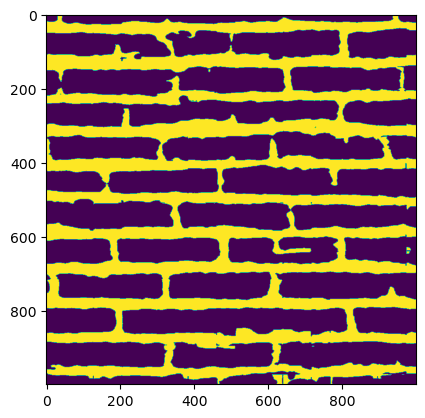

In [54]:
plt.imshow(x[0]>0.95)

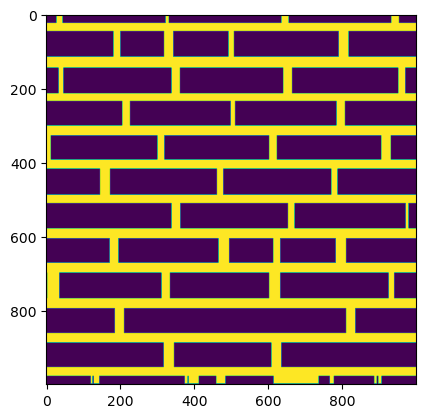

In [55]:
plt.imshow(x2)

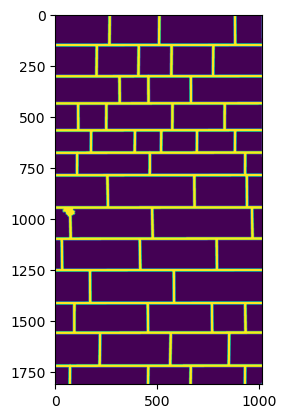

In [ ]:
from PIL import Image
mask = Image.open("testmask.tiff")
plt.imshow(mask)

In [ ]:
    #nesy IOU
    
    #im2 = ImageOps.grayscale(im2)
    prediction = np.array(x2)
    
   # THRESHOLD = 125
   # prediction = prediction > THRESHOLD
    prediction = prediction.astype(int)
    
    
  #  fig, ax = plt.subplots(1,2,figsize=(10, 20))
  #  ax1 = plt.subplot(1,2,1)
  #  plt.imshow(picout)
  #  ax2 = plt.subplot(1,2,2)
  #  plt.imshow(prediction)
  #  ax1.title.set_text('output')
  #  ax2.title.set_text('output binary')
    
    
    
  #  im = Image.open(test+testmask)
    target = np.array(mask)/255
    target = target>0.1
    target = target.astype(int)
    
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = np.sum(intersection) / np.sum(union)
    print(iou_score)
    differences = np.absolute(prediction-target)
    

0.6261928578573572


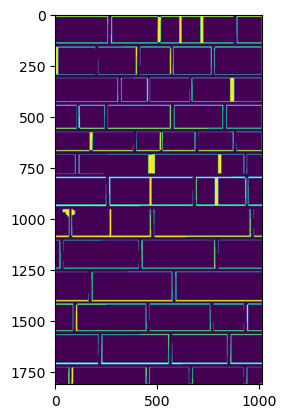

In [ ]:

plt.imshow(differences)

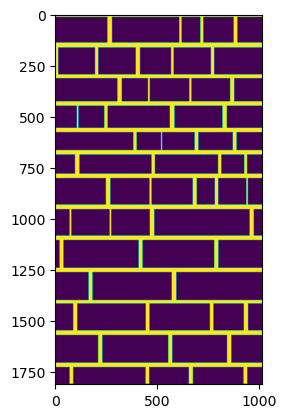

In [ ]:
plt.imshow(prediction)

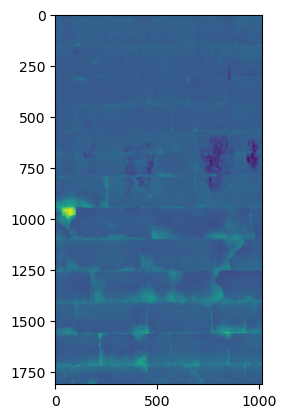

In [ ]:
original = Image.open("test.tiff")
originalnp = np.array(original)
plt.imshow(originalnp)

In [ ]:
#raw IOU
#im2 = ImageOps.grayscale(im2)
prediction = np.array(x[0])
THRESHOLD =  min(np.mean(prediction)+np.std(prediction),0.99)
prediction = prediction> THRESHOLD
# THRESHOLD = 125
# prediction = prediction > THRESHOLD
prediction = prediction.astype(int)


#  fig, ax = plt.subplots(1,2,figsize=(10, 20))
#  ax1 = plt.subplot(1,2,1)
#  plt.imshow(picout)
#  ax2 = plt.subplot(1,2,2)
#  plt.imshow(prediction)
#  ax1.title.set_text('output')
#  ax2.title.set_text('output binary')



#  im = Image.open(test+testmask)
target = np.array(mask)/255
target = target>0.1
target = target.astype(int)

intersection = np.logical_and(target, prediction)
union = np.logical_or(target, prediction)
iou_score = np.sum(intersection) / np.sum(union)
print(iou_score)
differences = np.absolute(prediction-target)

0.5808388610166447


In [ ]:
THRESHOLD

0.40885934534690516

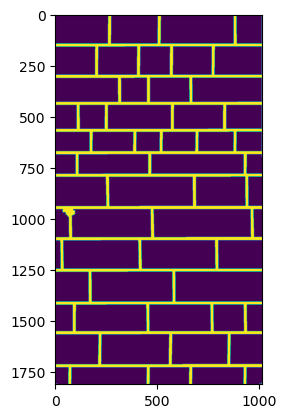

In [ ]:
plt.imshow(target)

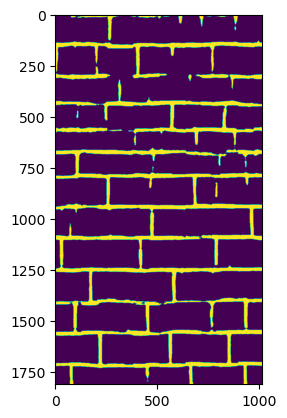

In [ ]:
plt.imshow(prediction)

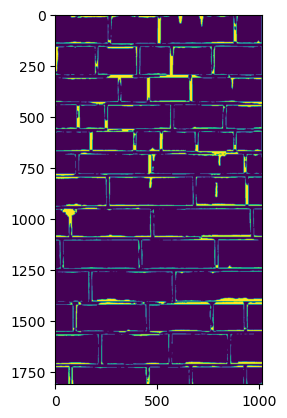

In [ ]:
plt.imshow(differences)

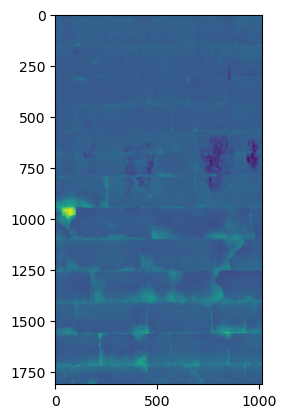

In [ ]:
original = Image.open("test.tiff")
originalnp = np.array(original)
plt.imshow(originalnp)

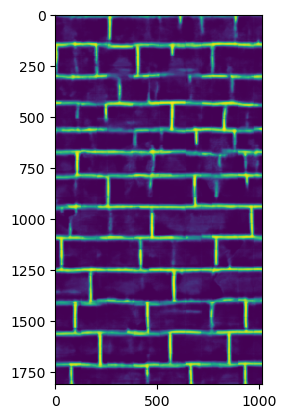

In [ ]:
plt.imshow(x[0])

In [ ]:
x2 = 0*x1
widthadd = 1
widthcheck = widthadd*2 +1
start = startindex[0]
end = endindex[1]

vjoints = 0*torch.sum(x[0][start:end,:],dim =0)
for n in range(0, widthcheck):
    vjoints[(widthadd):(-widthadd)] += torch.sum(x[0][start:end,(0+n):x[0].shape[1]-widthcheck+n+1],dim =0)/(widthcheck*(end-start))


In [ ]:
vjoints.max()

tensor(0.5225, dtype=torch.float64)

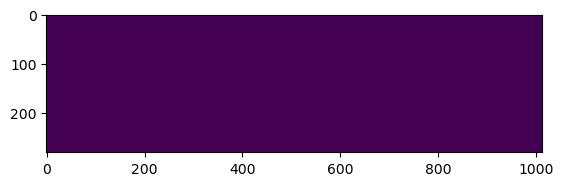

In [ ]:
plt.imshow(vjoints*torch.ones(x[0][start:end,:].shape)>0.6)

In [ ]:
vjoints = vjoints>0.3
vjointloc = vjoints
vjoints = torch.unsqueeze(vjoints,0)
vjoints = vjoints*torch.ones(x[0][start:end,:].shape)
x2[start:end,:] = 0*x1[start:end,:]+vjoints

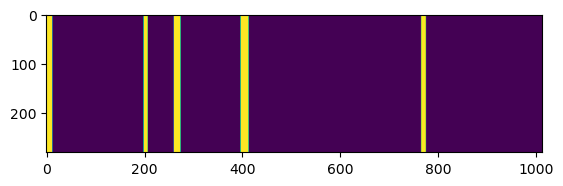

In [ ]:
plt.imshow(vjoints)

In [ ]:
len(x2.nonzero())

17422

In [ ]:
x2.mean()

tensor(0.0095, dtype=torch.float64)

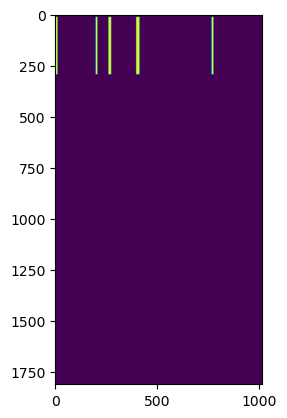

In [ ]:
plt.imshow(x2)

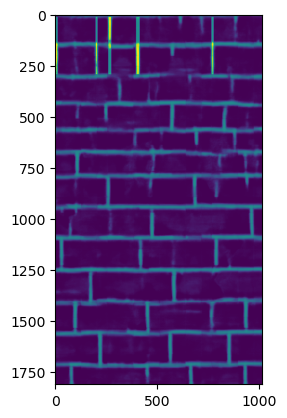

In [ ]:
plt.imshow(x[0]+x2)

In [ ]:
endindex[1:]

tensor([[ 295],
        [ 427],
        [ 557],
        [ 666],
        [ 781],
        [ 932],
        [1084],
        [1242],
        [1400],
        [1548],
        [1706],
        [1810]])

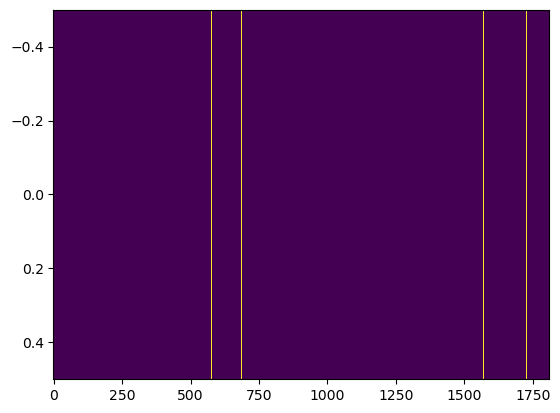

In [ ]:
plt.imshow(torch.unsqueeze(startx,0), interpolation='nearest', aspect='auto')

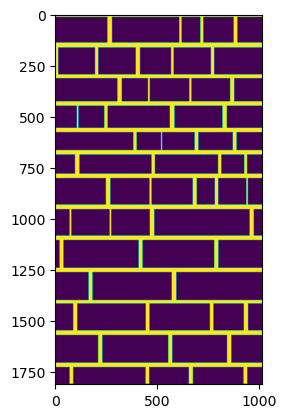

In [ ]:
plt.imshow(hjoints)

In [ ]:
hjoints.shape

torch.Size([1811, 1013])

In [ ]:
x[0].shape

torch.Size([1811, 1013])

In [ ]:
dataiter = iter(dataloader_training)

NameError: name 'dataloader_training' is not defined

In [ ]:
images, labels = dataiter.next()

In [ ]:
image = images[0]
images.shape

torch.Size([2, 1, 256, 256])

In [ ]:
images[0].shape

torch.Size([1, 256, 256])

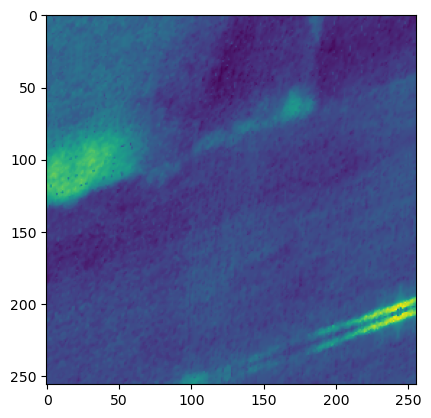

In [ ]:
plt.imshow(images[0][0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


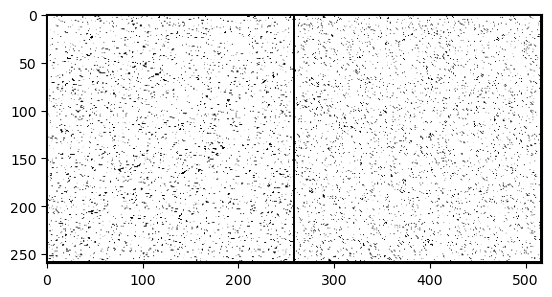

NameError: name 'classes' is not defined

In [ ]:
def timshow(x):
    xa = np.transpose(x.numpy(),(1,2,0))
    plt.imshow(xa)
    plt.show()
    
# get some random training images using the data loader
dataiter = iter(dataloader_training)
images, labels = dataiter.next()

# show images and labels
timshow(torchvision.utils.make_grid(images))

print(f"labels {[classes[labels[i]] for i in range(10)]}")


In [ ]:
def train():


        
        
        #results_path = './results_UNET_mobilenet_RGB200.pt'
        statsrec = np.zeros((2,nepochs))

       # loss_fn = nn.CrossEntropyLoss()
        #optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.01)
        optimizer = torch.optim.Adam(net.parameters(), lr=0.001, eps=1e-08,  weight_decay=0.00001)


        criterion = nn.BCEWithLogitsLoss(pos_weight=7*torch.ones([1])).to("cuda")
        for epoch in range(nepochs):  # loop over the dataset multiple times
            correct = 0          # number of examples predicted correctly (for accuracy)
            total = 0            # number of examples
            running_loss = 0.0   # accumulated loss (for mean loss)
            n = 0                # number of minibatches
            
            
            
            for data in dataloader_training:
                images, masks = data
                images, masks = images.to("cuda"), masks.to("cuda")

                 # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward, backward, and update parameters
                outputs1 = net(images)
                
                outputs = outputs1
                loss = criterion(outputs, masks)
                loss.backward()
                optimizer.step()

                # accumulate loss
                running_loss += loss.item()
                n += 1

                # accumulate data for accuracy
             #   _, predicted = torch.max(outputs.data, 1)
             #   total += labels.size(0)    # add in the number of labels in this minibatch
             #   correct += (predicted == labels).sum().item()  # add in the number of correct labels

            # collect together statistics for this epoch
            ltrn = running_loss/n
         #   atrn = correct/total 
            ltst = stats(dataloader_validation, net)



            print(f"epoch: {epoch} training loss: {ltrn: .3f}   test loss: {ltst: .3f} ")
            nepochsf = epoch

       #     print(ltrn)
        #    print(atrn)
         #   print(ltst)
          #  print(atst)
           # print(epoch)
            #print(statsrec)
           # print(ltrn.type())
            #print(atrn.type())
            #print(ltst.type())
            #print(atst.type())
            #print(epoch.type())
            #print(statsrec.type())
            statsrec[:,epoch] = (ltrn, ltst)
            
            if epoch >= 30:
                if 0.80*ltst >= ltrn:
                   break
            
        # save network parameters, losses and accuracy
        savestate = '/Final_epoch_{}{}{}.pt'.format(nepochsf, network, encoder)
        print(savestate)
        saveplace = results_path+savestate
        torch.save({"state_dict": net.state_dict(), "stats": statsrec}, saveplace)
        if test == 1:    
                iou_score2, precision,recall = UNETrun(inno, savestate, "depth", network, path, encoder, dim, "/test2.tiff","/testmask2.tiff", "default")
               # iou_scoresynthetic, precision,recall = UNETrun(inno, savestate, "depth", network, path, encoder, dim, "/testsynth.tiff","/testmasksynth.tiff", "default")
                iou_scoresynthetic = iou_score2
                iou_score, precision,recall = UNETrun(inno, savestate, "depth", network, path, encoder, dim, "/test.tiff","/testmask.tiff", "default")
        else:
            iou_score, iou_score2, iou_scoresynthetic, precision, recall = [0,0,0]
            

In [ ]:
iou_score, iou_score2, iou_scoresynthetic, precision, recall,nepochsf = train()